# Figure 2 in Stan and Mantripragada (2023)
The code tests whether there is overfitting during training. \
It will compute losses and plots the loss curves for training and validation. \
The overfitting analysis is done at a single grid point (lat: 0; lon: 160E).

In [1]:
import os
import numpy as np
import xarray as xr
import proplot as pplt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,DepthwiseConv1D,subtract

from pyisv.utils import remove_partial_year, check_nan, calc_anomalies, calc_lanczos_filtered_anomalies

C:\Users\ramsr\anaconda3\envs\newenv\lib\site-packages\proplot\__init__.py:73: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


#### Load interpolated NOAA OLR 
The interpolated OLR data is downloaded from: \
https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc \
For convenince, OLR files are renamed.

In [2]:
# NOAA interpolated daily mean OLR
olriFile = 'olr.day.interpolated.mean.nc'
olri = xr.open_dataset(olriFile).olr
olri = olri.reindex(lat=olri.lat[::-1])

#### Enter latitude and longitude
Check for NaNs. The input data should not contain NaNs. Replace the NaNs if present.

In [3]:
lat, lon = 0, 160
olri = olri.sel(lat=lat,lon=lon,method='nearest').sel(time=slice('1980',None))
# Check if the input data contains any NaNs. Get the location indices of NaNs if present.
nan_indices = check_nan(olri)

DataArray does not contain NaN values.


#### Get the years to split the dataset into training, validation, and testing. 

In [4]:
startTrain, endTrain, startVal, endVal = '1988', '2012', '2013', '2014'

### Calculate climatology, anomalies, and 30-90-day band pass filtered anomalies
Calculate climatology based only on the training period. This will avoid test data leakages or bias.

In [5]:
nwgths, tpa, tpb, filt_type  = 90, 30, 90, 'band' # The filter uses 181 (nwgths*2+1) weights; tpa, tpb: Time period

olri_anom, _ = calc_anomalies(olri, startTrain, endTrain, smooth_climatology=False)
olri_bpf = calc_lanczos_filtered_anomalies(olri_anom, nwgths, filt_type, tpa, tpb)

# Select the same time period for the unfiltered anomalies as the filtered anomalies
olri_anom = olri_anom.sel(time=slice(olri_bpf.time[0], olri_bpf.time[-1]))

# Remove the partial year data
olri_bpf = remove_partial_year(olri_bpf)
olri_anom = remove_partial_year(olri_anom)

#### Split the dataset into training, validation for a Convolutional Neural Network (CNN)

In [6]:
xtrain = olri_anom.sel(time=slice(startTrain, endTrain)).values
ytrain = olri_bpf.sel(time=slice(startTrain, endTrain)).values

xval = olri_anom.sel(time=slice(startVal, endVal)).values
yval = olri_bpf.sel(time=slice(startVal, endVal)).values

# Introduce new axis in order to satisy the input dimension requirements to a CNN model

xtrain1 = np.expand_dims(xtrain,axis=(0,2))
ytrain1 = np.expand_dims(ytrain,axis=(0,2))

xval1 = np.expand_dims(xval,axis=(0,2))
yval1 = np.expand_dims(yval,axis=(0,2))

#### Train the CNN model and plot the loss curve

In [7]:
#Model configuration

kernel1, kernel2 = 90, 30
no_epochs, verbosity = 1000, 0

inputs = Input(shape=(None,1),batch_size=1,name='input_layer')
smoth1 = DepthwiseConv1D(kernel_size=kernel1,padding='same',use_bias=False,activation='linear')(inputs)
diff = subtract([inputs, smoth1])
smoth2 = DepthwiseConv1D(kernel_size=kernel2,padding='same',use_bias=False,activation='linear')(diff)
model = Model(inputs=inputs, outputs=smoth2)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(1, None, 1)]       0           []                               
                                                                                                  
 depthwise_conv1d (DepthwiseCon  (1, None, 1)        90          ['input_layer[0][0]']            
 v1D)                                                                                             
                                                                                                  
 subtract (Subtract)            (1, None, 1)         0           ['input_layer[0][0]',            
                                                                  'depthwise_conv1d[0][0]']       
                                                                                              

In [8]:
history = model.fit(xtrain1,ytrain1,epochs=no_epochs,validation_data=(xval1, yval1),verbose=verbosity)

#### Figure2: Loss Curve

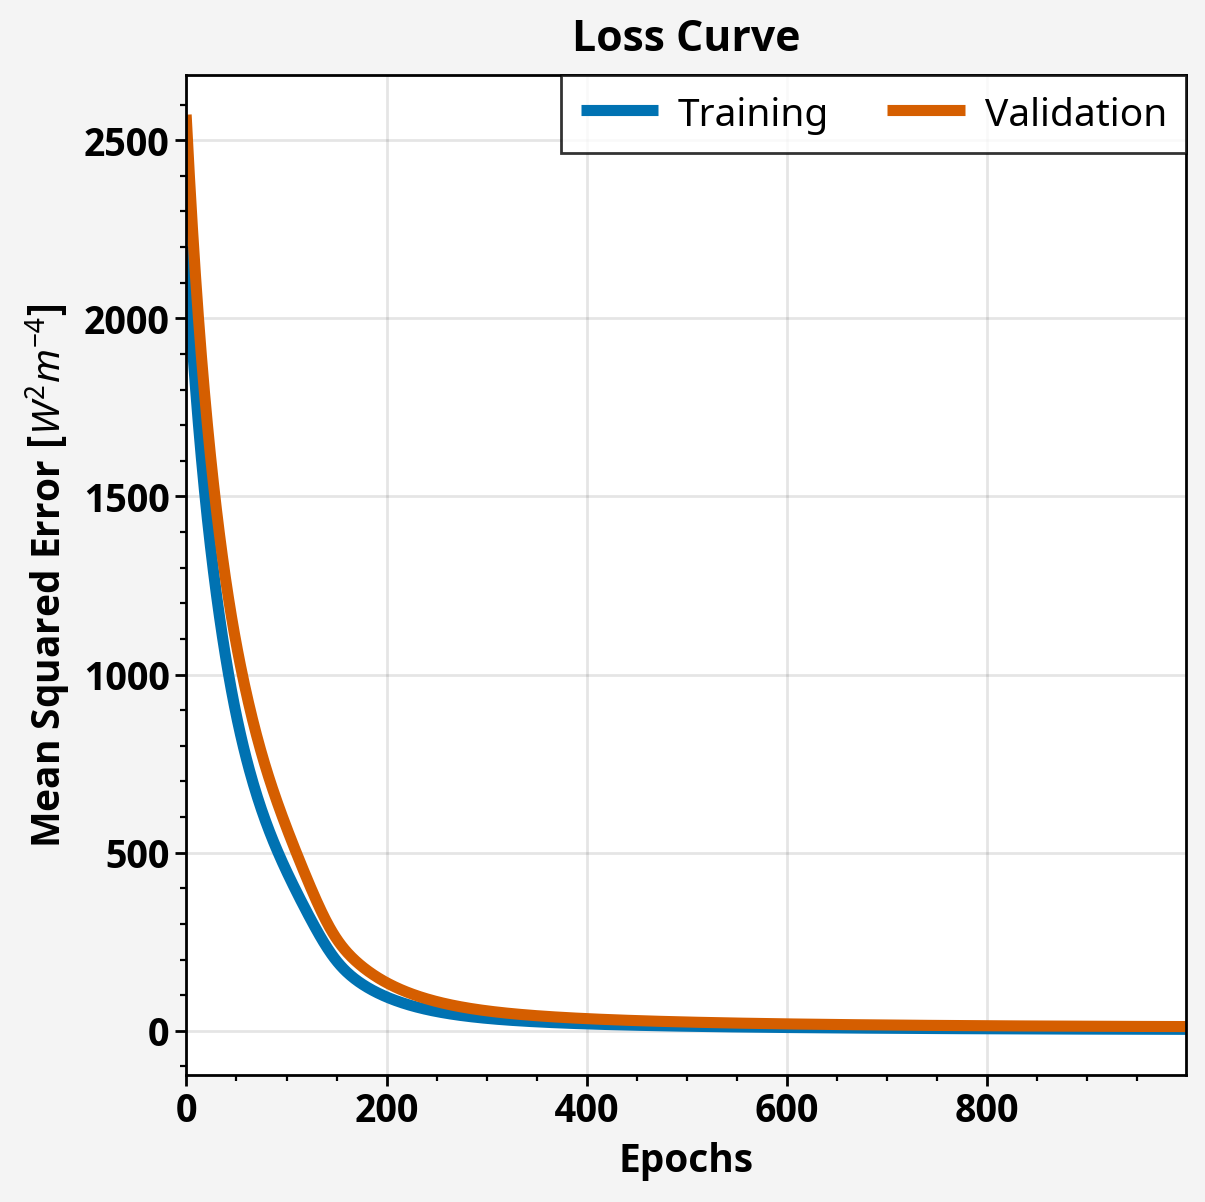

In [9]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':14,'titlesize':16})

fig = pplt.figure(refwidth=5,refheight=5,suptitle='Loss Curve')
ax = fig.subplot(xlabel='Epochs', ylabel='Mean Squared Error [$W^2m^{-4}$]')
ax.plot(history.history['loss'], lw=4,label='Training')
ax.plot(history.history['val_loss'], lw=4,label='Validation')
ax.legend(loc='ur')
fig.savefig('Fig2.png',dpi=150)